In [1070]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja
import numpy as np
from scipy import signal

In [1071]:
acce_file_path = "./PDR_1/Accelerometer.csv"
gyro_file_path = "./PDR_1/Gyroscope.csv"

# 通信してデータを取得
acce_data = pd.read_csv(acce_file_path,names=['timestamp','x','y','z'], header=0)
gyro_data = pd.read_csv(gyro_file_path,names=['timestamp','x','y','z'], header=0)

In [1072]:
acce_data['norm'] = (acce_data['y']**2 + acce_data['z']**2)**0.5
gyro_data['angle'] = np.cumsum(gyro_data['x']) / (len(gyro_data)-1) * (gyro_data['timestamp'].iloc[-1] - gyro_data['timestamp'].iloc[0])

<Figure size 640x480 with 0 Axes>

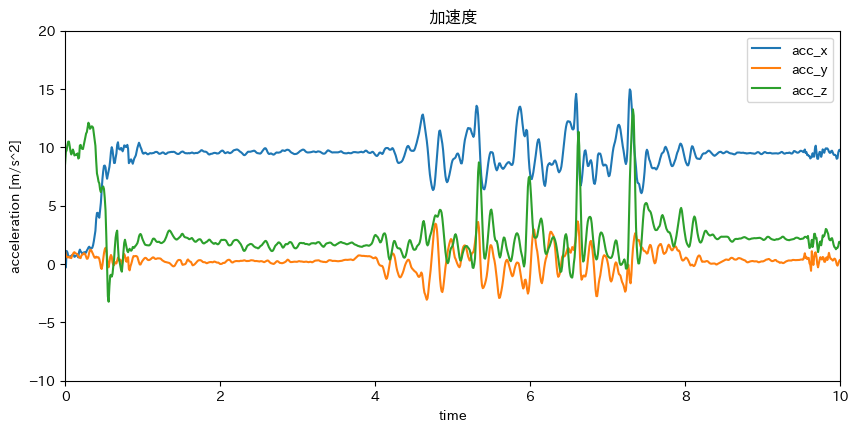

<Figure size 640x480 with 0 Axes>

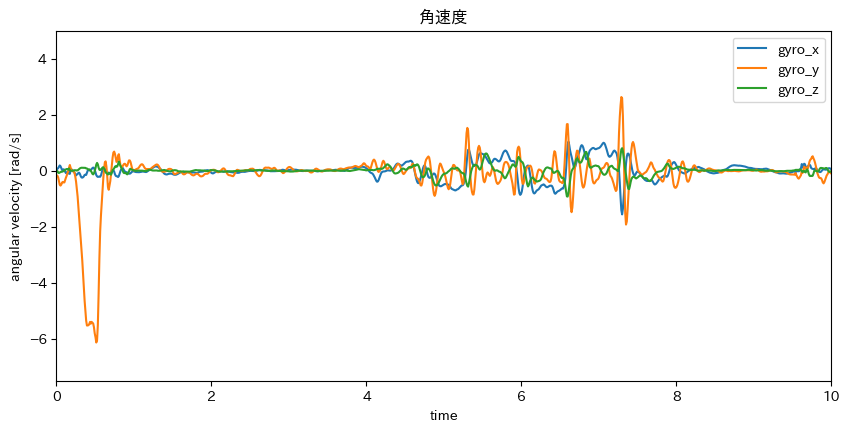

In [1073]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))

# 加速度のプロット
ax1 = fig.add_subplot(2,1,1)
ax1.title.set_text("加速度")
ax1.plot(acce_data["timestamp"], acce_data["x"], label="acc_x")
ax1.plot(acce_data["timestamp"], acce_data["y"], label="acc_y")
ax1.plot(acce_data["timestamp"], acce_data["z"], label="acc_z")
ax1.set_xlabel("time")
ax1.set_ylabel("acceleration [m/s^2]")
ax1.set_xlim(0, 10)
ax1.set_ylim(-10, 20)
ax1.legend()

plt.show()

# ジャイロのプロット
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(2,1,2)
ax2.title.set_text("角速度")
ax2.plot(gyro_data["timestamp"], gyro_data["x"], label="gyro_x")
ax2.plot(gyro_data["timestamp"], gyro_data["y"], label="gyro_y")
ax2.plot(gyro_data["timestamp"], gyro_data["z"], label="gyro_z")
ax2.set_xlabel("time")
ax2.set_ylabel("angular velocity [rad/s]")
ax2.set_xlim(0, 10)
ax2.set_ylim(-7.5, 5.0)
ax2.legend()

plt.show()

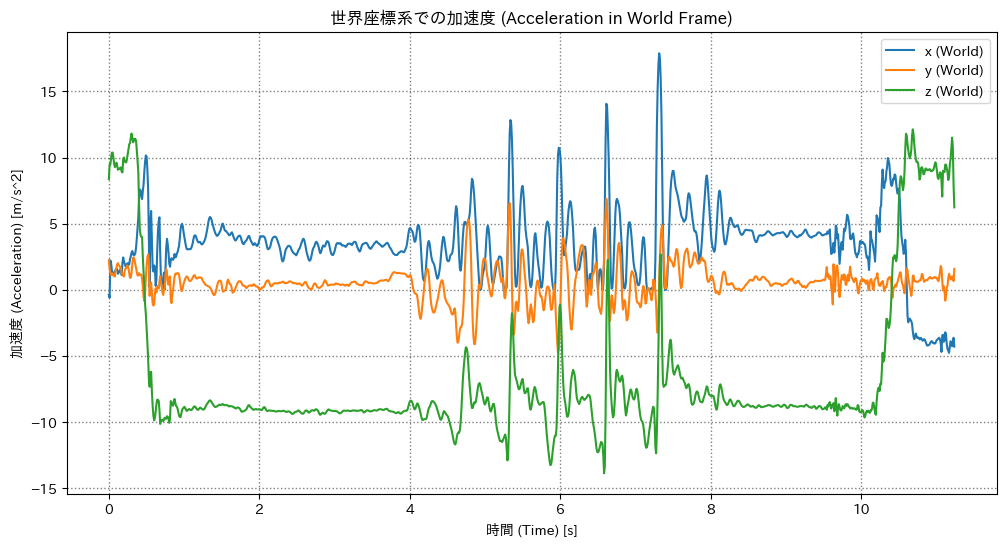

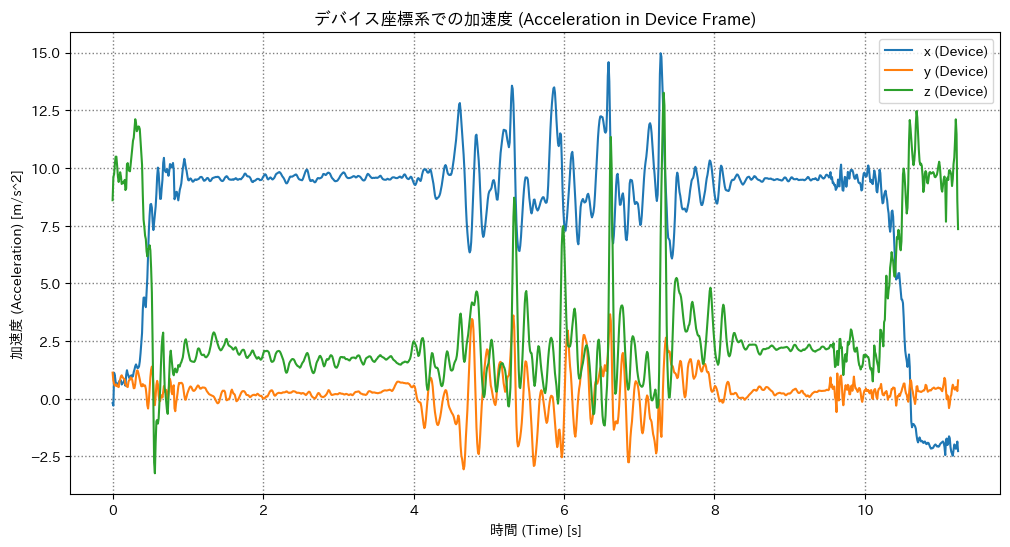

In [1074]:
# 世界座標系に変換された加速度データを格納するリスト
rotated_acc = []

# 元の加速度データの各行をループ
for row in acce_data.itertuples(index=False):
    timestamp, acc_x, acc_y, acc_z = row.timestamp, row.x, row.y, row.z

    # 1. 各時刻での傾き（ロール、ピッチ）を計算
    # X軸周りの回転角 (ロール)
    roll = np.arctan2(acc_y, acc_z)
    # Y軸周りの回転角 (ピッチ)
    pitch = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))
    # Z軸周りの回転角 (ヨー) は加速度センサからは不明なため0とする
    yaw = 0

    # 2. 回転行列を定義
    # デバイス座標系から世界座標系への変換は、
    # 「デバイスの傾きと逆方向に回転させる」ことと同じです。
    # そのため、角度の符号を反転させます (-roll, -pitch, -yaw)
    cos_r, sin_r = np.cos(-roll), np.sin(-roll)
    cos_p, sin_p = np.cos(-pitch), np.sin(-pitch)
    cos_y, sin_y = np.cos(-yaw), np.sin(-yaw)

    # ロール(X軸回転)の行列
    r_x = np.array([
        [1, 0, 0],
        [0, cos_r, -sin_r],
        [0, sin_r, cos_r]
    ])
    # ピッチ(Y軸回転)の行列
    r_y = np.array([
        [cos_p, 0, sin_p],
        [0, 1, 0],
        [-sin_p, 0, cos_p]
    ])
    # ヨー(Z軸回転)の行列
    r_z = np.array([
        [cos_y, -sin_y, 0],
        [sin_y, cos_y, 0],
        [0, 0, 1]
    ])

    # 3. 座標変換を実行
    vec = np.array([acc_x, acc_y, acc_z])
    
    # Z -> Y -> X の順番で回転を適用することが多い (ZYX順)
    rotated_vec = r_z @ r_y @ r_x @ vec

    # 回転後の値をリストに格納
    rotated_acc.append([timestamp, rotated_vec[0], rotated_vec[1], rotated_vec[2]])

# リストをDataFrameに変換
df_rotated_acc = pd.DataFrame(rotated_acc, columns=['timestamp', 'x', 'y', 'z'])
figsize = (12, 6)
# 4. グラフを描画
fig = plt.figure(figsize=figsize)

plt.title("世界座標系での加速度 (Acceleration in World Frame)")
plt.xlabel("時間 (Time) [s]")
plt.ylabel("加速度 (Acceleration) [m/s^2]")
plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

plt.plot(df_rotated_acc["timestamp"], df_rotated_acc["x"], label="x (World)")
plt.plot(df_rotated_acc["timestamp"], df_rotated_acc["y"], label="y (World)")
plt.plot(df_rotated_acc["timestamp"], df_rotated_acc["z"], label="z (World)")
plt.legend()

# 比較のために元の加速度もプロット
fig2 = plt.figure(figsize=figsize)
plt.title("デバイス座標系での加速度 (Acceleration in Device Frame)")
plt.xlabel("時間 (Time) [s]")
plt.ylabel("加速度 (Acceleration) [m/s^2]")
plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
plt.plot(acce_data["timestamp"], acce_data["x"], label="x (Device)")
plt.plot(acce_data["timestamp"], acce_data["y"], label="y (Device)")
plt.plot(acce_data["timestamp"], acce_data["z"], label="z (Device)")
plt.legend()

plt.show()

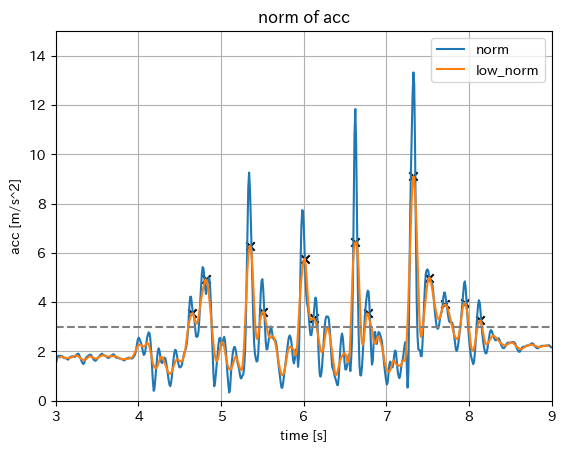

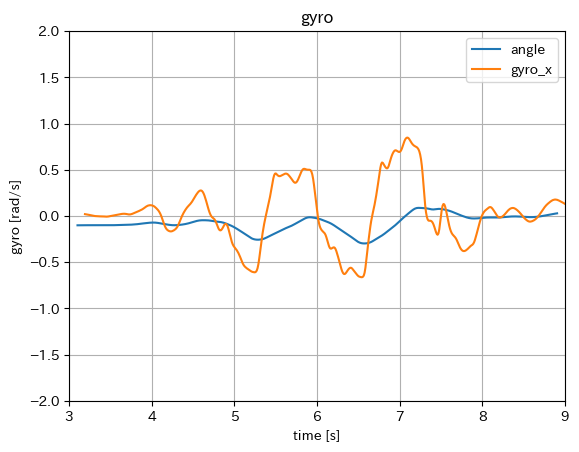

In [1075]:
acce_data = acce_data[(acce_data['timestamp'] < 9) & (acce_data['timestamp'] > 3)]
gyro_data = gyro_data[(gyro_data['timestamp'] < 9) & (gyro_data['timestamp'] > 3)]
acce_data = acce_data.reset_index(drop=True)
gyro_data = gyro_data.reset_index(drop=True)
acce_data['low_norm'] = acce_data['norm'].rolling(window=10, center=True).mean()
gyro_data['low_angle'] = gyro_data['angle'].rolling(window=20, center=True).mean()
gyro_data['low_x'] = gyro_data['x'].rolling(window=20).mean()

peaks, _ = signal.find_peaks(acce_data['low_norm'], distance=10, height=3)

plt.plot(acce_data['timestamp'], acce_data['norm'], label='norm')
plt.plot(acce_data['timestamp'], acce_data['low_norm'], label='low_norm')
plt.scatter(acce_data['timestamp'].iloc[peaks], acce_data['low_norm'].iloc[peaks], marker='x', color='black')
plt.axhline(3.0, color='gray', linestyle='--')
plt.plot()
plt.title('norm of acc')
plt.xlabel('time [s]')
plt.ylabel('acc [m/s^2]')
plt.ylim(0, 15)
plt.xlim(3, 9)
plt.legend()
plt.grid()
plt.show()

plt.plot(gyro_data['timestamp'], gyro_data['low_angle'], label='angle')
plt.plot(gyro_data['timestamp'], gyro_data['low_x'], label='gyro_x')
plt.title('gyro')
plt.xlabel('time [s]')
plt.ylabel('gyro [rad/s]')
plt.ylim(-2, 2)
plt.xlim(3, 9)
plt.grid()
plt.legend()
plt.show()

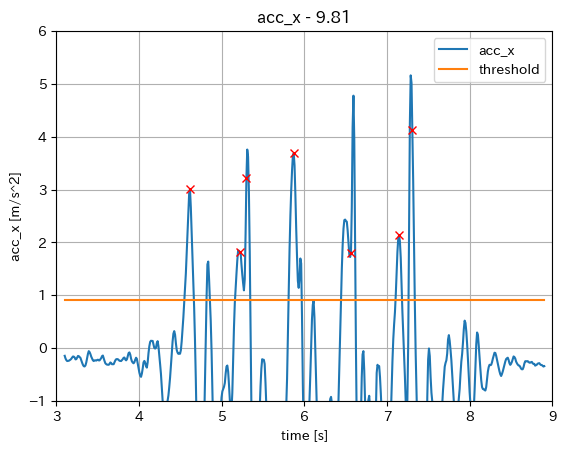

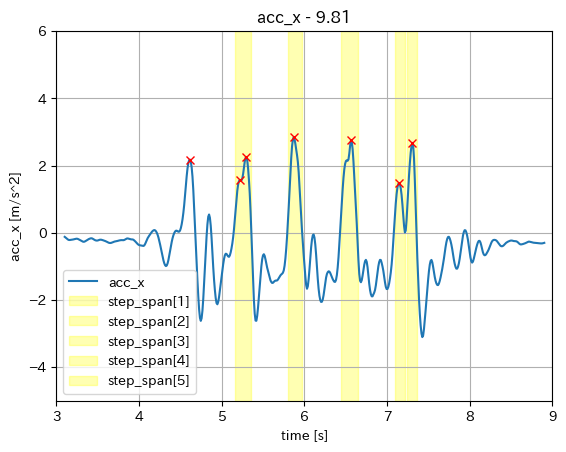

In [1076]:
# ステップの計算
acce_data['low_x_5'] = acce_data['x'].rolling(window=5, center=True).mean()
acce_data['low_x'] = acce_data['x'].rolling(window=10, center=True).mean()
acce_data['low_x_15'] = acce_data['x'].rolling(window=15, center=True).mean()
acce_data['low_x_20'] = acce_data['x'].rolling(window=20, center=True).mean()

acce_data = acce_data.dropna()
acce_data = acce_data.reset_index(drop=True)
x_peaks,_ = signal.find_peaks(acce_data['low_x'] - 9.81, distance=7, height=0.9)

plt.plot(acce_data['timestamp'], acce_data['x'] - 9.81, label='acc_x')
plt.plot(acce_data['timestamp'], [0.9]*len(acce_data['timestamp']), label='threshold')
plt.plot(acce_data['timestamp'].iloc[x_peaks], acce_data['x'].iloc[x_peaks] - 9.81, "x", color='red')
plt.xlim(3, 9)
plt.ylim(-1.0, 6.0)
plt.xlabel('time [s]')
plt.ylabel('acc_x [m/s^2]')
plt.title('acc_x - 9.81')
plt.legend()
plt.grid()
plt.show()


threshold = 10.0  # 閾値 (9.81を引いた後の値)
time_diff = 0.5  # ステップとみなすための最長時間 [s]
time_diff_min = 0.1  # ステップとみなすための最小時間 [s]

step_index_array = []
in_step = False
start_index = 0
# 重力加速度方向(x)の加速度に対して、ある閾値を2回超えたときにその範囲を一歩とみなす
for i in range(len(acce_data)):
    # 現在の加速度 
    current_acc = acce_data['low_x'][i]

    # ステップの内側にいない場合: 開始点を探す
    if not in_step:
        if current_acc > threshold:
            in_step = True
            start_index = i
            
    # ステップの内側にいる場合: 終了点を探す
    else:
        if current_acc < threshold:
            end_index = i
            
            # ステップの期間が時間の閾値を超えているか確認
            duration = acce_data['timestamp'][end_index] - acce_data['timestamp'][start_index]
            if duration < time_diff and duration > time_diff_min:
                step_index_array.append((start_index, end_index))

            # 状態をリセット
            in_step = False
plt.plot(acce_data['timestamp'], acce_data['low_x'] - 9.81, label='acc_x')

for step in step_index_array[1:]:
    first_index, second_index = step
    plt.axvspan(acce_data['timestamp'][first_index], acce_data['timestamp'][second_index], color='yellow', alpha=0.3,label='step_span[{}]'.format(step_index_array.index(step)))
plt.plot(acce_data['timestamp'].iloc[x_peaks], acce_data['low_x'].iloc[x_peaks] - 9.81, "x", color='red')
plt.xlim(3, 9)
plt.ylim(-5.0, 6.0)
plt.xlabel('time [s]')
plt.ylabel('acc_x [m/s^2]')
plt.title('acc_x - 9.81')
plt.legend()
plt.grid()
plt.show()


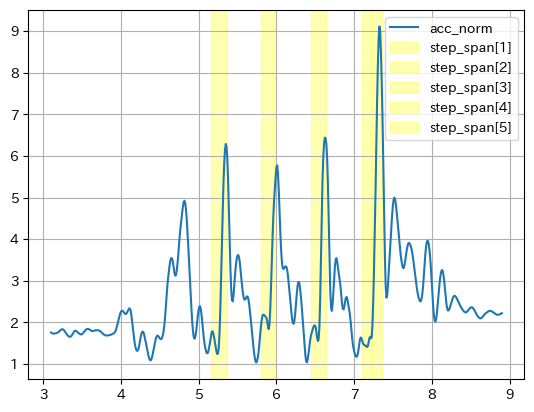

In [1077]:
# 一歩の区間の中から、ピークの検出を行う

plt.plot(acce_data['timestamp'], acce_data['low_norm'], label='acc_norm')
for step in step_index_array[1:]:
    first_index, second_index = step
    plt.axvspan(acce_data['timestamp'][first_index], acce_data['timestamp'][second_index], color='yellow', alpha=0.3,label='step_span[{}]'.format(step_index_array.index(step)))
plt.legend()
plt.grid()
plt.show()

# ピーク中の極大値から進行方向の推定を行う
peaks_in_step = []
for step in step_index_array[1:]:
    first_index, second_index = step
    step_peaks = [peak for peak in x_peaks if first_index <= peak <= second_index]
    peaks_in_step.append(step_peaks)

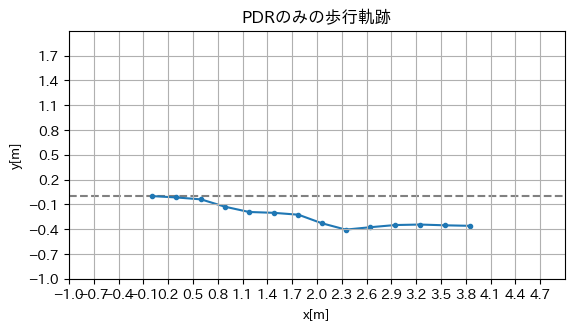

In [1078]:
step = 0.3
point = [[0, 0]]

# ステップから歩行軌跡を計算
for p in peaks:
    x = step * np.cos(gyro_data['low_angle'][p]*1.2) + point[-1][0]
    y = step * np.sin(gyro_data['low_angle'][p]*1.2) + point[-1][1]

    point.append([x, y])

point = pd.DataFrame(data=point, columns=['x', 'y'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

# 描画
size = ((-1,5), (-1, 2))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)

# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('PDRのみの歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 0.3))
plt.yticks(np.arange(size[1][0], size[1][1], 0.3))
plt.hlines(0, size[0][0], size[0][1], colors='gray', linestyles='--', zorder=0)
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

plt.grid()
plt.show()

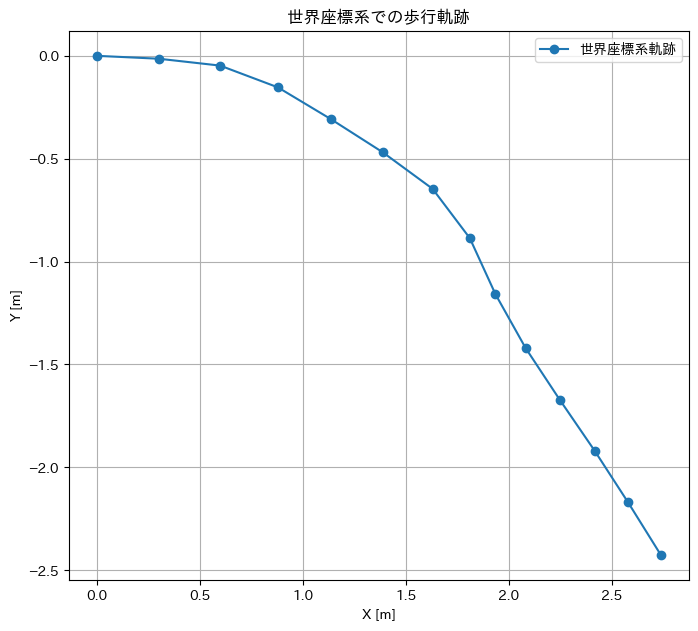

In [1079]:
# --- 世界座標系での歩行軌跡計算 ---
step_length = 0.3  # 歩幅[m]
points = [[0, 0]]  # 初期位置
theta = 0  # 初期進行方向（ラジアン, x軸正方向=0）
for p in peaks:
    # ジャイロから得た角度変化を累積
    theta += gyro_data['low_angle'].iloc[p]  # 角度を累積
    # 歩幅ベクトルを現在の進行方向に回転して加算
    dx = step_length * np.cos(theta)
    dy = step_length * np.sin(theta)
    new_point = [points[-1][0] + dx, points[-1][1] + dy]
    points.append(new_point)
points = np.array(points)

plt.figure(figsize=(8,8))
plt.plot(points[:,0], points[:,1], marker='o', label='世界座標系軌跡')
plt.title('世界座標系での歩行軌跡')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.legend()
plt.show()